## Method 3: Root Note Classifier

In [16]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm

A_FREQ = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

def note_from_freq(freq):
    r = 12.0*np.log2(freq/A_FREQ)
    return r

def freq_from_note(r):
    f = A_FREQ*2**(r/12)
    return f

# gets the maximum volume of the note in the fft image for a given note within a window of frequency
def get_note_volume(note,fft_image,fft_freq,note_window=0.2):
    if isinstance(note,str):
        note = NOTES.index(note)
    try:
        f0 = freq_from_note(note-note_window)
        f1 = freq_from_note(note+note_window)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except:
        return 0
    
    return maxVol

# gets the maximum volume of the note in the fft image for a given note over all octaves
def get_notes_volume(notes,fft_image,fft_freq,oct_from=-4.,oct_to=8.):
    # if note is a string, convert to index
    if isinstance(notes,str):
        notes = NOTES.index(notes)
    
    # get the notes in the range of octaves
    notes = np.arange(notes+12.*oct_from,notes+12.*oct_to,12.0)
    vol = []

    # get the volume of each note
    for rn in notes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    # return the maximum volume of that note
    return np.max(vol)


In [17]:
# given the chord quality, intervals and note volumes, create a model that predicts the root note using 
# Import necessary libraries

# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim'])]

train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


### Preprocessing

In [18]:
def preprocess(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32)
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    note_vols = np.zeros(12)

    for rnote in range(12):
        note_vols[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
    
    # get the indexes of the top 3 notes
    top_notes = note_vols.argsort()[-3:][::-1]
    
    # get the differences between the top 3 notes
    diffs = []
    for i in range(len(top_notes)-1):
        diffs.append(top_notes[i] - top_notes[i+1])
    
    diffs.append(top_notes[0] - top_notes[-1])

    return diffs, note_vols
 

### Feature Engineering

In [19]:
# disable the warnings
warnings.filterwarnings("ignore")

# add the diffs and note_vols columns to the train set, where each diff note_vol is a different column
for j in range(3):
    train_set['diff' + str(j)] = None

for k in range(12):
    train_set['note_vol' + str(k)] = None

diffs = []
note_vols = []
for i in tqdm(range(len(train_set))):
    diff, note_vol = preprocess(train_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            train_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            train_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)

for j in range(3):
    test_set['diff' + str(j)] = None

for k in range(12):
    test_set['note_vol' + str(k)] = None


for i in tqdm(range(len(test_set))):
    diff, note_vol = preprocess(test_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            test_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            test_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)


100%|██████████| 231/231 [00:01<00:00, 169.43it/s]


### Testing different Models

#### Decision Tree Classifier

In [20]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Convert chord quality to numeric using Label Encoding
le = LabelEncoder()
train_set['ChordQuality'] = le.fit_transform(train_set['Quality'])
test_set['ChordQuality'] = le.fit_transform(test_set['Quality'])


# Define features (X) and target variable (y)
X = train_set.drop(columns=['Root Note', 'File Path', 'Inversion', 'Octave'])
y = train_set['Root Note']
X['Quality'] = le.fit_transform(X['Quality'])


X_test = test_set.drop(columns=['Root Note', 'File Path', 'Inversion', 'Octave'])
y_test = test_set['Root Note']
X_test['Quality'] = le.fit_transform(X_test['Quality'])

# Create a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree_model.fit(X, y)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8268398268398268


#### K-Nearest Neighbours

In [21]:
# do the same thing with KNN
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model
model = KNeighborsClassifier(n_neighbors=2)

# Train the model
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5151515151515151


#### Random Forest Classifier

In [22]:
# try the same thing with Random Forest
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X, y)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.922077922077922


#### Feed-Forward Neural Network

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming you have X and y loaded from your dataset

# Convert 'Root Note' values to their corresponding indices
NOTES = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
y = y.replace('Eb', 'D#')
y = y.replace('Bb', 'A#')
y = y.replace('Ab', 'G#')
y_test = y_test.replace('Eb', 'D#')
y_test = y_test.replace('Bb', 'A#')
y_test = y_test.replace('Ab', 'G#')
y_encoded = np.array([NOTES.index(note) for note in y])
y_test_encoded = np.array([NOTES.index(note) for note in y_test])


# Ensure that data types are compatible with TensorFlow
X_train = X.astype(np.float32)  # Adjust the data type accordingly
y_train = y_encoded.astype(np.int32)    # Adjust the data type accordingly
X_test = X_test.astype(np.float32)    # Adjust the data type accordingly
y_test = y_test_encoded.astype(np.int32)      # Adjust the data type accordingly

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/100
5/5 [==============================] - 0s 24ms/step - loss: 3.6855 - accuracy: 0.0820 - val_loss: 2.4707 - val_accuracy: 0.0654
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 3.5034 - accuracy: 0.1030 - val_loss: 2.4424 - val_accuracy: 0.0935
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 3.3494 - accuracy: 0.1101 - val_loss: 2.4134 - val_accuracy: 0.1869
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 3.1333 - accuracy: 0.1429 - val_loss: 2.3809 - val_accuracy: 0.2430
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 3.1543 - accuracy: 0.1358 - val_loss: 2.3489 - val_accuracy: 0.2430
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 2.7893 - accuracy: 0.1780 - val_loss: 2.3189 - val_accuracy: 0.2897
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 2.7813 - accuracy: 0.2061 - val_loss: 2.2893 - val_accuracy: 0.3271
Epoch 8/100
5/5 [=========

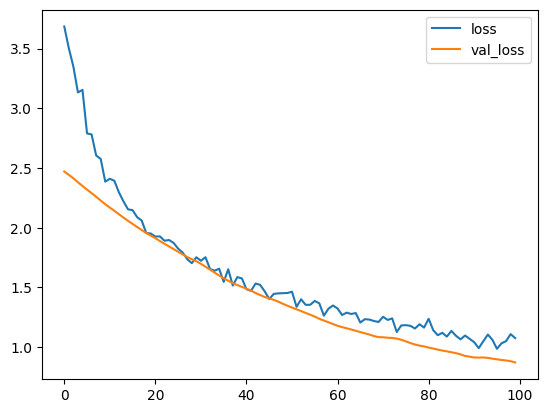

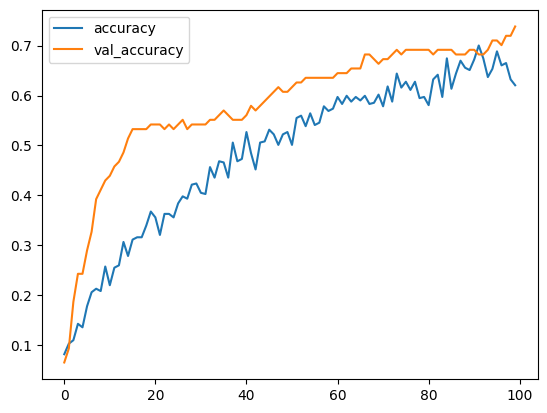

In [25]:
from tensorflow.keras.layers import BatchNormalization


ffnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(17,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(12, activation='sigmoid')
])


ffnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = ffnn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    batch_size=100,
    epochs=100,
    verbose=1
)

# Evaluate the model on the test set
results = ffnn_model.evaluate(X_test_scaled, y_test)

# Plot the accuracy and loss curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

# Make predictions with the model
y_pred = ffnn_model.predict(X_test_scaled)

# Get the predicted class with the highest probability for each sample
y_pred_encoded = np.argmax(y_pred, axis=1)
# y_pred_notes = [NOTES[index] for index in y_pred_encoded]

# Get the classification report
report = classification_report(y_test_encoded, y_pred_encoded)
print(report)


In [26]:
test_loss, test_accuracy = ffnn_model.evaluate(X_test_scaled, y_test, verbose=2)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

8/8 - 0s - loss: 0.8565 - accuracy: 0.7403 - 17ms/epoch - 2ms/step
Test loss: 0.86. Test accuracy: 74.03%


#### Attempted Ensemble Model

In [28]:
# set up an ensemble method: use 50% from the decision tree, 50% from the neural network
# get the predictions from the decision tree
y_pred_dt = decision_tree_model.predict(X_test)
y_pred_dt_modified = np.copy(y_pred_dt)
y_pred_dt_modified[y_pred_dt_modified == 'Eb'] = 'D#'
y_pred_dt_modified[y_pred_dt_modified == 'Bb'] = 'A#'
y_pred_dt_modified[y_pred_dt_modified == 'Ab'] = 'G#'
y_pred_dt_encoded = [NOTES.index(note) if note in NOTES else -1 for note in y_pred_dt_modified]

# get the predictions from the neural network
y_pred_nn = ffnn_model.predict(X_test_scaled)
y_pred_nn_encoded = np.argmax(y_pred_nn, axis=1)

# get the predictions from the random forest
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_modified = np.copy(y_pred_dt)
y_pred_rf_modified[y_pred_rf_modified == 'Eb'] = 'D#'
y_pred_rf_modified[y_pred_rf_modified == 'Bb'] = 'A#'
y_pred_rf_modified[y_pred_rf_modified == 'Ab'] = 'G#'
y_pred_rf_encoded = [NOTES.index(note) if note in NOTES else -1 for note in y_pred_rf_modified]

# combine the predictions
y_pred_combined = []
for i in range(len(y_pred_dt_encoded)):
    y_pred_combined.append([y_pred_dt_encoded[i], y_pred_nn_encoded[i], y_pred_rf_encoded[i]])

# get the most common prediction
y_pred_combined_encoded = []
for i in range(len(y_pred_combined)):
    y_pred_combined_encoded.append(np.bincount(y_pred_combined[i]).argmax())

# get the classification report
report = classification_report(y_test_encoded, y_pred_combined_encoded)
print(report)

8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.89      0.73      0.80        22
           2       0.73      0.80      0.76        10
           3       0.59      0.83      0.69        12
           4       0.94      0.80      0.86        20
           5       0.76      0.90      0.83        21
           6       0.84      0.80      0.82        20
           7       0.84      0.94      0.89        17
           8       0.95      0.64      0.77        28
           9       0.63      0.75      0.69        16
          10       0.90      0.90      0.90        29
          11       1.00      0.95      0.97        20

    accuracy                           0.83       231
   macro avg       0.82      0.83      0.82       231
weighted avg       0.84      0.83      0.83       231



In [29]:
# get the accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_combined_encoded)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8268398268398268
